In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.datasets import mnist

In [ ]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

def sigmoid_prime(z):
  return z*(1-z)

def relu(z):
  return np.maximum(z,0)

def relu_prime(z):
  return (z>=0) * 1.0

def softmax(z):
  e_z = np.exp(z-z.max(axis=1, keepdims=True))
  return e_z/e_z.sum(axis=1, keepdims=True)

def cross_entropy(y_pred, y_true):
  return (-y_true*np.log(y_pred)).sum()/y_true.shape[0]

In [ ]:
nx=784 #input node fixed
nh1 = 200
nh2 = 32
ny = 10 #output node fixed

learning_rate=0.1
epoch=10
nbatch=32
r1 = 0.9
r2 = 0.999
epsilon = 1e-8

In [ ]:
class SimpleMLP:
  def __init__(self):
    # self.weight = {'W1': np.random.randn(nx,nh1)/np.sqrt((nx+nh1)/2),
    #                'W2': np.random.randn(nh1,nh2)/np.sqrt((nh1+nh2)/2),
    #                'W3': np.random.randn(nh2,ny)/np.sqrt((nh2+ny)/2),}
    self.weight = {'W1': np.random.randn(nx,nh1)/np.sqrt((nx)/2),
                   'W2': np.random.randn(nh1,nh2)/np.sqrt((nh1)/2),
                   'W3': np.random.randn(nh2,ny)/np.sqrt((nh2)/2),}
    self.layer={}
    self.gradient={}
    self.momentum={'W1':0, 'W2':0, 'W3':0}
    self.rms={'W1':0, 'W2':0, 'W3':0}
    self.iter=0

  def save_weight(self):
    with open('weight_backup.pkl','wb') as fo:
      pickle.dump(self.weight, fo)

  def load_weight(self):
    with open('weight_backup.pkl','rb') as fi:
      self.weight = pickle.load(fi)

  def feedforward(self, x):
    W1 = self.weight['W1']
    W2 = self.weight['W2']
    W3 = self.weight['W3']

    z1 = np.dot(x, W1)
    h1 = relu(z1)
    z2 = np.dot(h1, W2)
    h2 = relu(z2)
    z3 = np.dot(h2, W3)
    y = softmax(z3)

    self.layer = {'z1':z1, 'h1':h1, 'z2':z2, 'h2':h2, 'z3':z3, 'y':y}
    return y

  def train_step(self, x, y_true):
    m = x.shape[0]

    y_pred = self.feedforward(x)

    loss = cross_entropy(y_pred, y_true)
    acc = np.count_nonzero(np.argmax(y_pred, axis=1) == np.argmax(y_true,axis=1))/m

    W2, W3 = self.weight['W2'], self.weight['W3']
    h1, h2 = self.layer['h1'], self.layer['h2']
    z1, z2 = self.layer['z1'], self.layer['z2']

    dLdz3 = (y_pred - y_true)/m
    gradW3 = np.dot(h2.T, dLdz3)

    dLdh2 = np.dot(dLdz3, W3.T)
    dLdz2 = dLdh2 * relu_prime(z2)
    gradW2 = np.dot(h1.T, dLdz2)

    dLdh1 = np.dot(dLdz2, W2.T)
    dLdz1 = dLdh1 * relu_prime(z1)
    gradW1 = np.dot(x.T, dLdz1)

    self.gradient = {'W1':gradW1, 'W2':gradW2, 'W3':gradW3}
    self.adam_opt()

    return loss, acc

  def sgd_opt(self):
    for W in self.weight:
      self.weight[W] = self.weight[W] -learning_rate * self.gradient[W]

  def adam_opt(self):
    for W in self.weight:
      self.momentum[W] = self.momentum[W] * r1 + self.gradient[W]
      self.rms[W] = self.rms[W] * r2 + (self.gradient[W]**2)*(1-r2)

      self.iter +=1
      V_hat = self.momentum[W]/(1-r1**self.iter)
      G_hat = self.rms[W]/(1-r2**self.iter)

      self.weight[W] = self.weight[W]-learning_rate*V_hat/(np.sqrt(G_hat)+epsilon)



In [ ]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

# print(X_train[0])

# plt.imshow(X_train[1], cmap='gray')
# plt.show()

print(Y_train[0])

5


In [ ]:
X_train = X_train.reshape((-1,784))/255.0
X_test = X_test.reshape((-1,784))/255.0

net = SimpleMLP()

success = 0
failure = 0

# for x,gt in zip(X_test,Y_test):
#   x = x.reshape((-1,784))
#   logits = net.feedforward(x)
#   if np.argmax(logits) == gt:
#     success +=1
#   else:
#     failure +=1

# print(f"accuracy: {success/(success+failure)*100}%")

In [ ]:
n = Y_train.size
Y_train_onehot = np.zeros((n,10))
Y_train_onehot[np.arange(n), Y_train] = 1

In [ ]:
loss_list=[]
acc_list=[]

N = X_train.shape[0]
idx = np.arange(N)


for k in range(epoch):
  np.random.shuffle(idx)

  loss_total = 0.0
  acc_total = 0.0

  for i in range(0,N,nbatch):
    bi = idx[i:i+nbatch]

    bx = X_train[bi]
    by = Y_train_onehot[bi]

    loss, acc = net.train_step(bx, by)
    loss_total += loss*bx.shape[0]
    acc_total += acc*bx.shape[0]

    if(i/nbatch)%10 == 0:
      loss_list.append(loss)
      acc_list.append(acc)

  print(f"epoch: {k}, avg loss: {loss_total/N}, accuracy: {acc_total/N}")

net.save_weight()



<ipython-input-62-03a238fcc52e>:18: RuntimeWarning: divide by zero encountered in log
  return (-y_true*np.log(y_pred)).sum()/y_true.shape[0]
<ipython-input-62-03a238fcc52e>:18: RuntimeWarning: invalid value encountered in multiply
  return (-y_true*np.log(y_pred)).sum()/y_true.shape[0]


epoch: 0, avg loss: nan, accuracy: 0.0995
epoch: 1, avg loss: 2.302585092994027, accuracy: 0.09871666666666666
epoch: 2, avg loss: 2.302585092994027, accuracy: 0.09871666666666666
epoch: 3, avg loss: 2.302585092994027, accuracy: 0.09871666666666666
epoch: 4, avg loss: 2.302585092994027, accuracy: 0.09871666666666666
epoch: 5, avg loss: 2.302585092994027, accuracy: 0.09871666666666666


KeyboardInterrupt: 

In [ ]:
net = SimpleMLP()
net.load_weight()

success = 0
failure = 0
failed_data=[]

for x,gt in zip(X_test,Y_test):
  x = x.reshape((-1,784))
  logits = net.feedforward(x)
  if np.argmax(logits) == gt:
    success +=1
  else:
    failure +=1
    failed_data.append((x.reshape((28,28)),gt, np.argmax(logits)))

print(f"accuracy: {success/(success+failure)*100}%")

accuracy: 98.15%


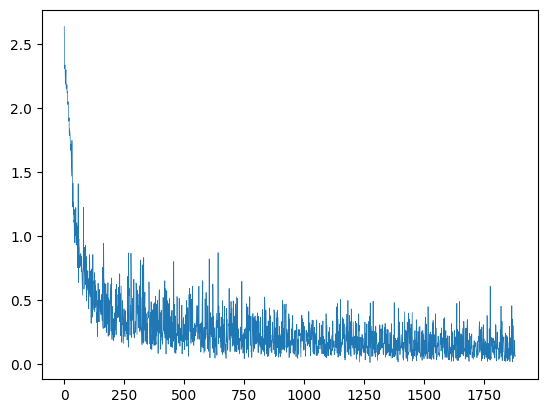

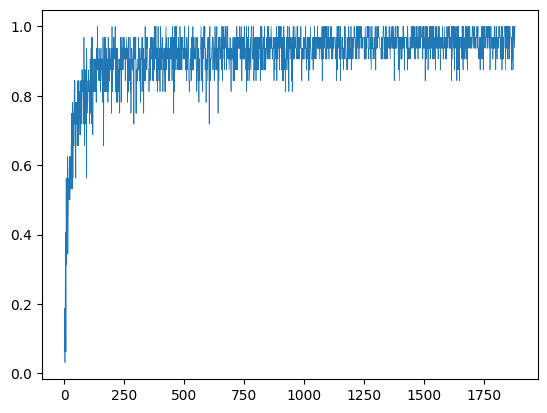

In [ ]:
plt.plot(loss_list, lw=0.5)
plt.show()
plt.plot(acc_list,lw=0.5)
plt.show()

185
label: 2
predict: 8


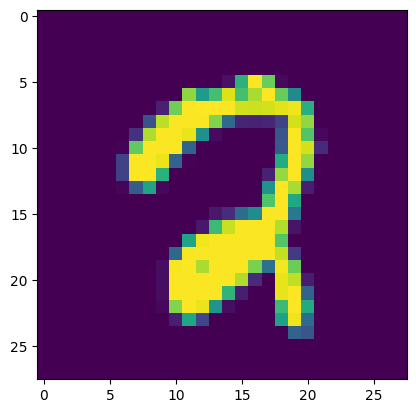

In [ ]:
print(len(failed_data))

img,gt,pred = failed_data[0]
print(f"label: {gt}")
print(f"predict: {pred}")
plt.imshow(img)
plt.show()